<a href="https://colab.research.google.com/github/eyao600/resnet9/blob/main/resnet_add_hidden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The Resnet Research paper can be accessed from here https://arxiv.org/pdf/1512.03385v1.pdf

# **Checking availability of GPU. Google Colab provides a NVIDIA Tesla

K80 GPU for free for 12 hours.**

##Some Features of Tesla K80

1.4992 NVIDIA CUDA cores with a dual-GPU design

2.Up to 2.91 teraflops double-precision performance with NVIDIA GPU Boost

3.Up to 8.73 teraflops single-precision performance with NVIDIA GPU Boost

3.24 GB of GDDR5 memory

4.480 GB/s aggregate memory bandwidth

5.ECC protection for increased reliability

6.Server-optimised to deliver the best throughput in the data center


#**CUDA®**
CUDA® is a parallel computing platform and programming model developed by NVIDIA for general computing on graphical processing units (GPUs). With CUDA, developers are able to dramatically speed up computing applications by harnessing the power of GPUs.

In GPU-accelerated applications, the sequential part of the workload runs on the CPU – which is optimized for single-threaded performance – while the compute intensive portion of the application runs on thousands of GPU cores in parallel. When using CUDA, developers program in popular languages such as C, C++, Fortran, Python and MATLAB and express parallelism through extensions in the form of a few basic keywords.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


#**Downloading the CIFAR10 datset and loading the data in Normalized form as torch.FloatTensor datatype and generating a validation set by dividing the training set in 80-20 ratio**
#**CIFAR10**
The CIFAR10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

More can be read from their page at https://www.cs.toronto.edu/~kriz/cifar.html

#**Image Augmentation**
In this cell, we perform some simple data augmentation by randomly flipping and cropping the given image data. We do this by defining a torchvision transform, and you can learn about all the transforms that are used to pre-process and augment data from the [PyTorch documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


==> Preparing data..


100%|██████████| 170M/170M [00:03<00:00, 47.5MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#**Visualizing the Data**
Obtaining a batch of training data and plot the same with its lables using matplotlib library. You can also see how the transformations which you applied in the previous step show up in these visualizations.

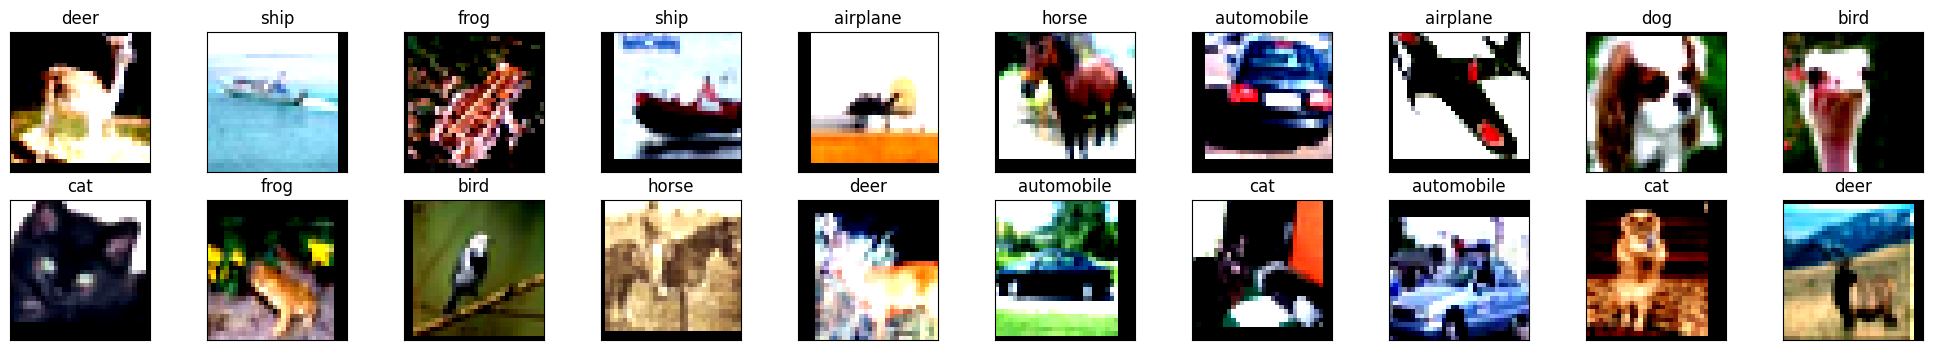

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

#**View an Image in More Detail**
Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

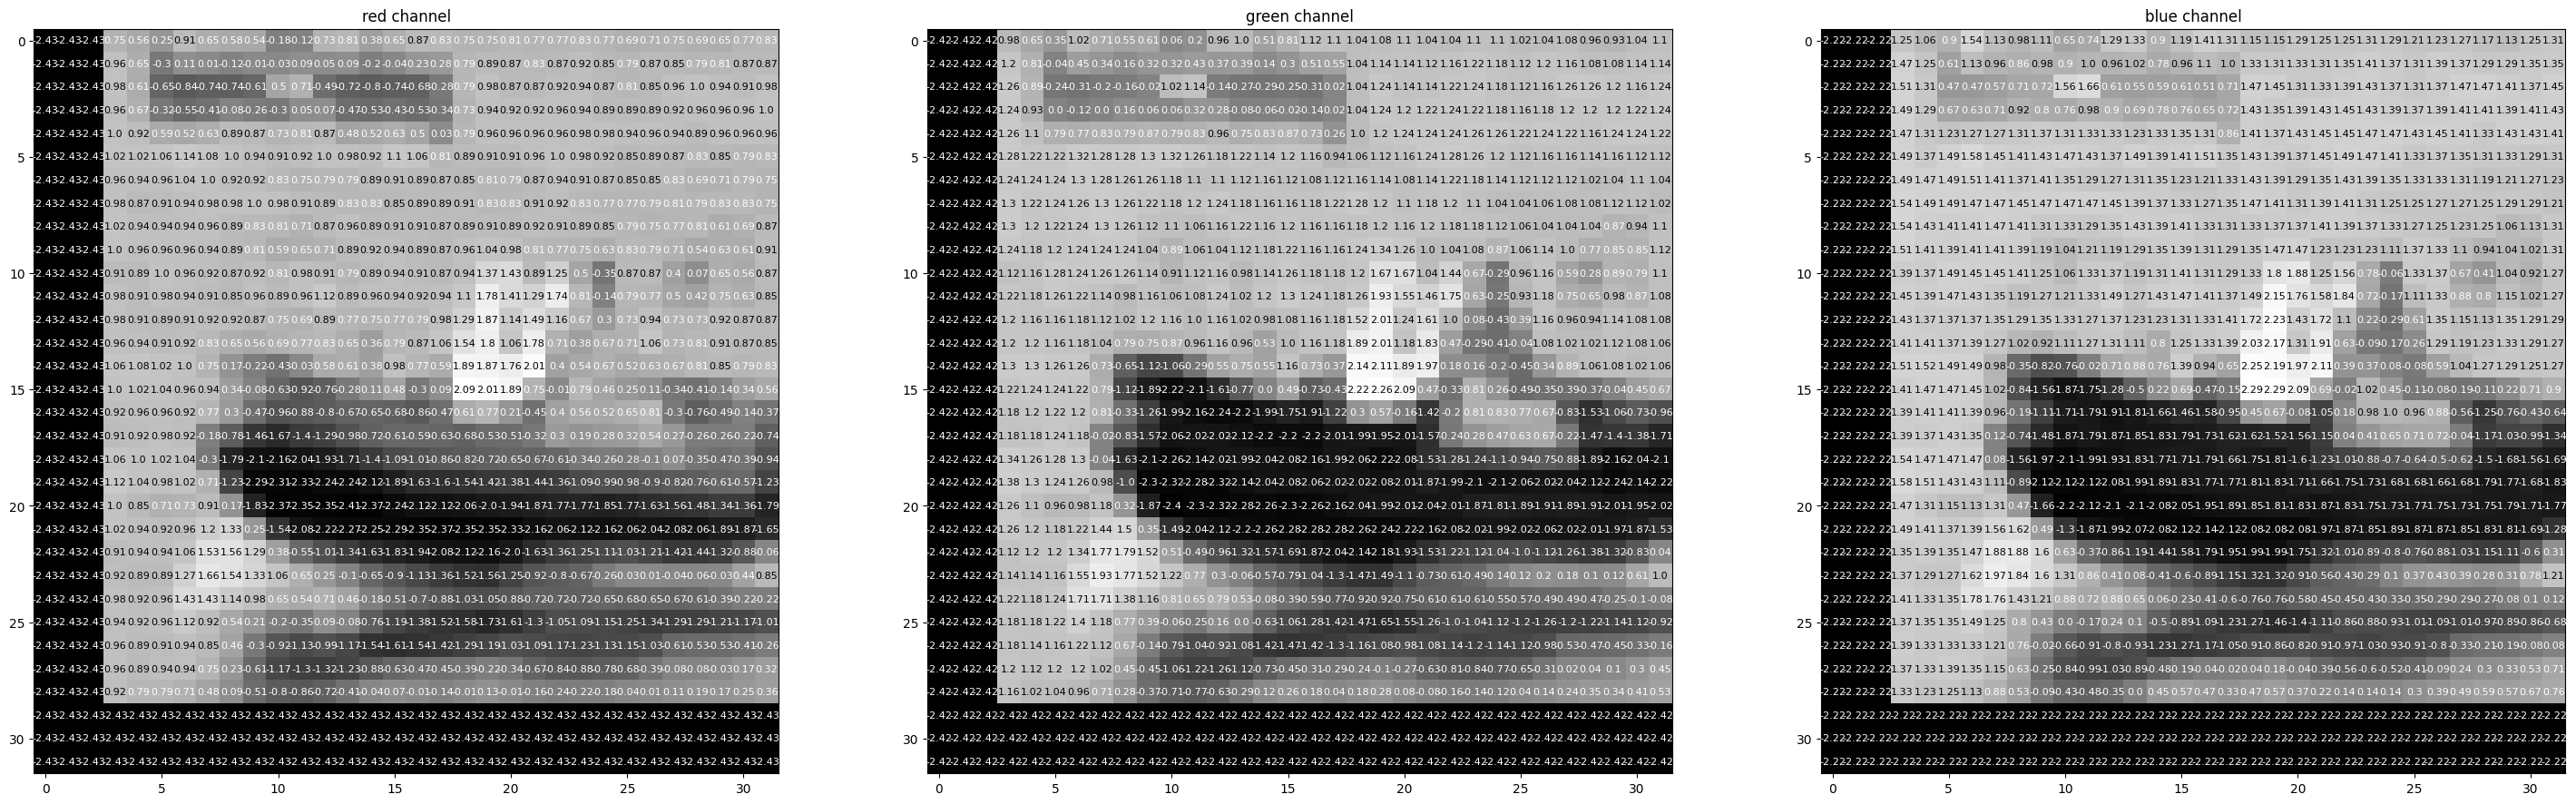

In [4]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx + 1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] !=0 else 0
      ax.annotate(str(val), xy=(y,x),
      horizontalalignment='center',
      verticalalignment='center', size=8,
      color='white' if img[x][y]<thresh else 'black')

#**Defining the Network Architecture**
ResNet9 architecture is described in https://github.com/davidcpage/cifar10-fast/tree/master



In [5]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

class ConvBN(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return F.relu(self.bn(self.conv(x)))

class Residual(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.res1 = ConvBN(channels, channels)
    self.res2 = ConvBN(channels, channels)

  # downsampling not required when number of input and output channels are the same
  def forward(self, x):
    out = self.res2(self.res1(x))
    out = out + x # identity shortcut connection
    return out

class Layer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.convbn = ConvBN(in_channels, out_channels)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    return self.pool(self.convbn(x))

class ResLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.layer = Layer(in_channels, out_channels)
    self.residual = Residual(out_channels)

  def forward(self, x):
    return self.residual(self.layer(x))

class ResNet9(nn.Module):
  def __init__(self, input_size=32, num_classes=10):
    super().__init__()
    self.prep = ConvBN(3, 2*input_size)
    self.layer1 = ResLayer(2*input_size, 4*input_size)
    self.layer2 = Layer(4*input_size, 8*input_size)
    self.layer3 = ResLayer(8*input_size, 16*input_size)
    #self.pool = nn.MaxPool2d(4)
    #self.flatten = nn.Flatten()

    #self.linear = nn.Linear(16*input_size, 10, bias=False)
    self.linear1 = nn.Linear(16*input_size, 64, bias=False) # hidden layer for HW simulation interface
    self.linear2 = nn.Linear(64, 10, bias=False)

  def forward(self, x):
    x = self.prep(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = F.avg_pool2d(x, 4)
    x = x.view(x.size(0), -1)
    #x = self.linear(x)
    x = self.linear1(x)
    x = self.linear2(x)
    return x

In [6]:
in_size = 32
input = torch.randn(20,3,in_size,in_size)
model = ResNet9(input_size=in_size)
print(model(input).shape)

torch.Size([20, 10])


In [7]:
model = ResNet9()
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f'total parameters: {total_params}')

if train_on_gpu:
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

ResNet9(
  (prep): ConvBN(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer1): ResLayer(
    (layer): Layer(
      (convbn): ConvBN(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (residual): Residual(
      (res1): ConvBN(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (res2): ConvBN(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tru

#**Specifying the Loss Function and Optimizer**
We use CrossEntropyLoss as Loss function and

[Stochastic Gradient Descent](https://leon.bottou.org/publications/pdf/compstat-2010.pdf) as Optimizer with momentum and weight decay specified by the research paper of ResNet

In [8]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# **Initialize Model Parameters**

In [9]:
from itertools import product

def decode_binary_str(F_str):
    F = sum([2 ** -(i + 1) * int(a) for i, a in enumerate(F_str)]) * 2 ** len(F_str)
    return F

def generate_binary_values(num_total_bits = 8, num_exponent_bits = 3):
  num_fraction_bits = num_total_bits - 1 - num_exponent_bits
  all_values = []
  for S in [1,0]:
        for E_str_iter in product(*[[0, 1]] * num_exponent_bits):
            for F_str_iter in product(*[[0, 1]] * num_fraction_bits):
                E_str = "".join(str(i) for i in E_str_iter)
                F_str = "".join(str(i) for i in F_str_iter)
                bin = str(S) + E_str + F_str
                all_values.append(bin)
  return all_values

def generate_all_values_fp(
    num_total_bits: int = 8, num_exponent_bits: int = 4, bias: int = 8
) -> list:
    num_fraction_bits = num_total_bits - 1 - num_exponent_bits

    all_values = []
    exp_lower = -bias
    for S in [-1.0, 1.0]:
        for E_str_iter in product(*[[0, 1]] * num_exponent_bits):
            for F_str_iter in product(*[[0, 1]] * num_fraction_bits):
                E_str = "".join(str(i) for i in E_str_iter)
                F_str = "".join(str(i) for i in F_str_iter)

                # encoded exponent
                E_enc = decode_binary_str(E_str)
                E_eff = E_enc - bias
                if E_eff == exp_lower:
                    is_subnormal = 1
                else:
                    is_subnormal = 0

                F_enc = decode_binary_str(F_str) * 2**-num_fraction_bits
                F_eff = F_enc + 1 - is_subnormal

                fp8_val = S * 2.0 ** (E_enc - bias + is_subnormal) * F_eff
                all_values.append(fp8_val)
    res = np.array(all_values)
    # res = np.sort(res)
    return res


def generate_all_float_values_scaled(num_total_bits, num_exp_bits, exp_bias, range_limit_fp):
    grid = generate_all_values_fp(num_total_bits, num_exp_bits, exp_bias)
    float_max_abs_val = np.max(np.abs(grid))

    float_scale = float_max_abs_val / range_limit_fp
    floats_all = grid / float_scale
    return floats_all

In [11]:
from collections import OrderedDict
import numpy as np

state_dict = torch.load('ResNet9_hidden.pt') if train_on_gpu else torch.load('ResNet9_hidden.pt', map_location=torch.device('cpu'))

if state_dict:
  if not train_on_gpu:
    new_state_dict = OrderedDict()
    for k,v in state_dict.items():
      new_state_dict[k[7:]] = v
    state_dict = new_state_dict
  model.load_state_dict(state_dict)

  last_layer_weights = next(reversed(state_dict.items()))[1]
  # print(last_layer_weights.shape)

  n_bits = 8
  e_bits = 3
  e_bias = 2 ** (e_bits-1)-1
  grid = generate_all_values_fp(n_bits, e_bits, e_bias) # convert to binary
  grid_bin = generate_binary_values(n_bits, e_bits)
  # w = last_layer_weights.numpy()
  # print(grid)
  # print(grid_bin)

  map = {}
  for i,b in enumerate(grid_bin):
    map[b] = grid[i]

  print(map)
  '''
  w = torch.rand(3,3).numpy()
  print(w)
  shape = w.shape
  for k,v in enumerate(w.flat):
    diff = np.abs(np.subtract(grid, v))
    i = np.argmin(diff)
    w.flat[k] = grid_bits[i]

  weights = w.reshape(shape)
  print(weights)
  '''

{'10000000': -0.0, '10000001': -0.015625, '10000010': -0.03125, '10000011': -0.046875, '10000100': -0.0625, '10000101': -0.078125, '10000110': -0.09375, '10000111': -0.109375, '10001000': -0.125, '10001001': -0.140625, '10001010': -0.15625, '10001011': -0.171875, '10001100': -0.1875, '10001101': -0.203125, '10001110': -0.21875, '10001111': -0.234375, '10010000': -0.25, '10010001': -0.265625, '10010010': -0.28125, '10010011': -0.296875, '10010100': -0.3125, '10010101': -0.328125, '10010110': -0.34375, '10010111': -0.359375, '10011000': -0.375, '10011001': -0.390625, '10011010': -0.40625, '10011011': -0.421875, '10011100': -0.4375, '10011101': -0.453125, '10011110': -0.46875, '10011111': -0.484375, '10100000': -0.5, '10100001': -0.53125, '10100010': -0.5625, '10100011': -0.59375, '10100100': -0.625, '10100101': -0.65625, '10100110': -0.6875, '10100111': -0.71875, '10101000': -0.75, '10101001': -0.78125, '10101010': -0.8125, '10101011': -0.84375, '10101100': -0.875, '10101101': -0.90625, 

<ipython-input-11-2d3d84618cba>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('ResNet9_hidden.pt') if train_on_gpu else torch.load('ResNet9_hidden

# **Quantization of Last Layer**

In [12]:
# https://medium.com/@rekalantar/how-to-visualize-layer-activations-in-pytorch-d0be1076ecc3

model.eval()

# Hook setup
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
if train_on_gpu:
  model.module.linear1.register_forward_hook(get_activation('linear1'))
else:
  model.linear1.register_forward_hook(get_activation('linear1'))

In [13]:
# https://github.com/Qualcomm-AI-research/FP8-quantization/blob/main/quantization/quantizers/fp8_quantizer.py
def quantize_to_e3m4(x_float):
  E = 3
  M = torch.tensor(4)

  maxval = torch.max(x_float)
  minval = -maxval

  bias = 2**E - torch.log2(maxval) + torch.log2(2 - 2 ** (-M)) - 1
  xc = torch.min(torch.max(x_float, minval), maxval)

  log_scales = torch.clamp((torch.floor(torch.log2(torch.abs(xc)) + bias)).detach(), 1.0)
  scales = 2.0 ** (log_scales - M - bias)

  result = torch.round(xc / scales) * scales
  return result

def quantization_e3m4(weights, activations):
  q_activation = quantize_to_e3m4(activations)
  q_weight = quantize_to_e3m4(weights)
  #print(q_activation.shape, q_weight.shape)
  return quantize_to_e3m4(torch.matmul(q_activation, torch.transpose(q_weight,0,1)))

In [14]:
def scale_to_fp8(x, e_bias = 3):
  max = torch.max(x)
  return 2**(e_bias+2) / max

def e3m4_bin(x): # takes numpy array
  #print(x_np[0])
  shape = x.shape
  x_bin = []
  for val in x.flat:
    i = np.argmin(np.abs(grid - val))
    x_bin.append(grid_bin[i])
  return np.reshape(x_bin,shape)
  #print(x_bin[0])

# e3m4_bin(w_fp8.numpy())

def quant_to_e3m4_bin(x):
  x_scale = scale_to_fp8(x)
  x_fp8 = quantize_to_e3m4(x) * x_scale
  return e3m4_bin(x_fp8.cpu().numpy())

In [15]:
import csv

#data = quant_to_e3m4_bin(last_layer_weights)
data = last_layer_weights

with open('weights.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerows(data)

In [ ]:
''' TO DO
# https://www.geeksforgeeks.org/python-program-to-represent-floating-number-as-hexadecimal-by-ieee-754-standard/
def float_bin(my_number, places = 3):
    my_whole, my_dec = str(my_number).split(".")
    my_whole = int(my_whole)
    res = (str(bin(my_whole))+".").replace('0b','')

    for x in range(places):
        my_dec = str('0.')+str(my_dec)
        temp = '%1.20f' %(float(my_dec)*2)
        my_whole, my_dec = temp.split(".")
        res += my_whole
    return res

def e3m4_bin(n):
  # identifying whether the number
  # is positive or negative
  sign = 0
  if n < 0 :
      sign = 1
      n = n * (-1)
  p = 30
  # convert float to binary
  dec = float_bin(n, places = p)
  dotPlace = dec.find('.')
  onePlace = dec.find('1')
  # print(dec, dotPlace, onePlace)
  # finding the mantissa
  if onePlace > dotPlace:
    dec = dec.replace(".","")
    onePlace -= 1
    dotPlace -= 1
  elif onePlace < dotPlace:
    dec = dec.replace(".","")
    dotPlace -= 1
  mantissa = dec[onePlace+1:]

  # calculating the exponent(E)
  exponent = dotPlace - onePlace
  exponent_bits = exponent + 3

  if(exponent_bits < 0): # subnormal
    exponent_bits = 0
    mantissa = dec[3:]

  # converting the exponent from
  # decimal to binary
  exponent_bits = bin(exponent_bits).replace("0b",'')

  mantissa = mantissa[0:4]

  # notation in binary
  final = str(sign) + exponent_bits.zfill(3) + mantissa
  return final

for n in grid:
  bin_str = e3m4_bin(n)
  if(n != map[bin_str]):
    print("ERR: ", n, " != ", bin_str)

# e3m4_bin(-0.5)
'''

In [ ]:
def quantize_to_int4(x_float):
  pass

#**Training Loop**
Here we train the architecture on training data and check its validation loss by using the validation set and saving the model only if there is an improvement ie decrease in the validation loss.

In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  ###################
  # train the model #
  ###################
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)

  ######################
  # validate the model #
  ######################
  model.eval()
  for batch_idx, (data, target) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss
    valid_loss += loss.item()*data.size(0)

  # calculate average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  # print training/validation statistics
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))

  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(model.state_dict(), 'ResNet9_hidden.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.236327 	Validation Loss: 0.230976
Validation loss decreased (inf --> 0.230976).  Saving model ...
Epoch: 2 	Training Loss: 0.213775 	Validation Loss: 0.216246
Validation loss decreased (0.230976 --> 0.216246).  Saving model ...
Epoch: 3 	Training Loss: 0.202067 	Validation Loss: 0.244955
Epoch: 4 	Training Loss: 0.198083 	Validation Loss: 0.255683
Epoch: 5 	Training Loss: 0.178018 	Validation Loss: 0.238760
Epoch: 6 	Training Loss: 0.172327 	Validation Loss: 0.246556
Epoch: 7 	Training Loss: 0.166579 	Validation Loss: 0.233754
Epoch: 8 	Training Loss: 0.151727 	Validation Loss: 0.240129


KeyboardInterrupt: 

#**Loading the Best Model**

In [39]:
model.load_state_dict(torch.load('ResNet9_hidden.pt'))

<ipython-input-39-d1fa05ead50d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ResNet9_hidden.pt'))


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

#**Testing Loop**
The real test of the model architecture how well does the model recognizes the image and what is the accuracy on the test data

In [22]:
# track test loss
#test_loss = 0.0
class_correct = list(0. for i in range(10))
q_class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
q_class_total = list(0. for i in range(10))

act_data = []
out_data = []
pred_data = []

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(data)
  '''
  for x in quant_to_e3m4_bin(activations['linear1']):
    act_data.append(x)
  '''
  for x in output.detach().cpu().numpy():
    out_data.append(x)

  q_output = quantization_e3m4(last_layer_weights, activations['linear1'])
  quant_error = torch.sub(output, q_output)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss
  #test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  _, q_pred = torch.max(q_output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  q_correct_tensor = q_pred.eq(target.data.view_as(q_pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  q_correct = np.squeeze(q_correct_tensor.numpy()) if not train_on_gpu else np.squeeze(q_correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    x = []
    label = target.data[i]
    x.append(int(label))
    x.append(classes[label])
    class_correct[label] += correct[i].item()
    q_class_correct[label] += q_correct[i].item()
    class_total[label] += 1
    q_class_total[label] += 1
    pred_data.append(x)

with open('activations.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerows(act_data)

with open('output.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerows(out_data)

with open('predictions.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerows(pred_data)
# average test loss
#test_loss = test_loss/len(test_loader.dataset)
#print('Test Loss: {:.6f}\n'.format(test_loss))
print('No Quantization')
for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print('Quantized (E3M4)')
for i in range(10):
  if q_class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * q_class_correct[i] / q_class_total[i],
        np.sum(q_class_correct[i]), np.sum(q_class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(q_class_correct) / np.sum(q_class_total),
    np.sum(q_class_correct), np.sum(q_class_total)))

No Quantization
Test Accuracy of airplane: 80% (807/1000)
Test Accuracy of automobile: 95% (952/1000)
Test Accuracy of  bird: 88% (884/1000)
Test Accuracy of   cat: 79% (795/1000)
Test Accuracy of  deer: 90% (900/1000)
Test Accuracy of   dog: 76% (762/1000)
Test Accuracy of  frog: 94% (949/1000)
Test Accuracy of horse: 88% (885/1000)
Test Accuracy of  ship: 93% (934/1000)
Test Accuracy of truck: 93% (933/1000)

Test Accuracy (Overall): 88.01% (8801/10000)
Quantized (E3M4)
Test Accuracy of airplane: 80% (809/1000)
Test Accuracy of automobile: 95% (956/1000)
Test Accuracy of  bird: 88% (889/1000)
Test Accuracy of   cat: 80% (806/1000)
Test Accuracy of  deer: 89% (896/1000)
Test Accuracy of   dog: 75% (752/1000)
Test Accuracy of  frog: 94% (947/1000)
Test Accuracy of horse: 88% (880/1000)
Test Accuracy of  ship: 93% (932/1000)
Test Accuracy of truck: 93% (931/1000)

Test Accuracy (Overall): 87.98% (8798/10000)
